# Automatic Forecasting with TempEst-NEXT

This Notebook automatically generates forecasts out to 17 days for a specified watershed.  It will eventually include three approaches:

1. Pour point forecast: one watershed.
2. Nested forecast: the whole upstream system at kilometer resolution, run as tightly-nested lumped models.
3. Interpolated forecast: the whole upstream system, using kilometer-scale smart interpolation or a reach model between confluences.

For convenience, it is assumed that the downstream point is a USGS gage.  However, NEXT's automatic data retrieval tools can work with coordinates as well, with no gage required.

We will set up the watershed model based on 5 years of daymet data (2018-2022), then run the next 17 days with GFS data.

# Setup and Watershed Identification

ERROR 1: PROJ: proj_create_from_database: Open of /u/wy/ch/dphilippus/.conda/envs/next/share/proj failed


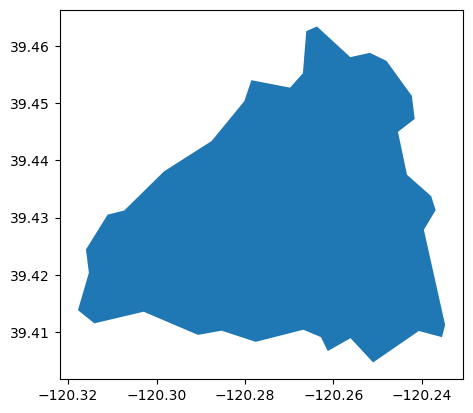

In [1]:
import NEXT
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import dataretrieval.nwis as nwis
# USGS gage as downstream location
site = "10343500"    # Sagehen Creek nr Truckee, CA.  Small mountain watershed in Eastern Sierra.
# site = "01646500"    # Potomac R near Little Falls Pump Stn., DC.  Large river near AGU24.  Possibly skewed by discharges.
# site = "01638500"    # Potomac R. at Point of Rocks, MD.  A little upstream to avoid the alteration.
NEXT.data.gage_geom(site)[0].plot()
model = NEXT.NEXT.from_pickle("coefs.pickle")  # prepare a coefficient estimation model

# Pour Point Forecast

We are assuming the pour point is a USGS gage (which is not necessary).  If it has stream temperature, we can come back later and check our forecasts.

## Forecast

### Model Preparation

In [2]:
dpath = f"site_cache/prep_data_{site}.csv"
if os.path.exists(dpath):
    ws_data = pd.read_csv(dpath, dtype={"id": "str"}, parse_dates=["date"])
else:
    ws_data = NEXT.data.full_data(site, "2018-01-01", "2022-12-31", site_type="usgs")
    ws_data.to_csv(dpath, index=False)

In [3]:
newt = model.make_newt(ws_data, use_climate=False).get_newt()  # for a 5-year period of record, we don't need the climate engine.

### Actual Forecast

In [26]:
# Data Prep.  We also want to get the last week or so as inputs to the anomaly function.
earlier = (datetime.date.today() - datetime.timedelta(6)).strftime("%Y-%m-%d")
today = datetime.date.today().strftime("%Y-%m-%d")
fcst_path = f"site_cache/inp_forecast_{site}_{today}.csv"
end = (datetime.date.today() + datetime.timedelta(16)).strftime("%Y-%m-%d")
if os.path.exists(fcst_path):
    fcst_input = pd.read_csv(fcst_path, dtype={"id": "str"}, parse_dates=["date"])
else:
    recent = NEXT.data.full_data(site, earlier, today, weather="gfs")
    recent = recent[recent["date"] < pd.to_datetime(today)]
    fcst_input = pd.concat([recent, NEXT.data.full_data(site, today, end, weather="gfs")])
    fcst_input.index = range(len(fcst_input))
    fcst_input.to_csv(fcst_path, index=False)
fcst_input

,id,id_type,lat,lon,area,water,developed,barren,forest,shrubland,...,unknown,ice_snow,elev,slope,elev_min,date,tmax,vp,srad,prcp
0,10343500,usgs,39.431572,-120.237979,2.525875e+07,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.9973,0.000196,1929.513428,2024-11-15,-0.43683,488.076270,315.186667,1.300320
1,10343500,usgs,39.431572,-120.237979,2.525875e+07,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.9973,0.000196,1929.513428,2024-11-16,2.33954,358.566287,266.160000,0.272160
2,10343500,usgs,39.431572,-120.237979,2.525875e+07,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.9973,0.000196,1929.513428,2024-11-17,8.49826,517.532488,261.199985,0.000000
3,10343500,usgs,39.431572,-120.237979,2.525875e+07,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.9973,0.000196,1929.513428,2024-11-18,3.59200,566.817910,254.600000,1.589760
4,10343500,usgs,39.431572,-120.237979,2.525875e+07,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.9973,0.000196,1929.513428,2024-11-19,0.92100,305.397457,178.019990,0.120960
5,10343500,usgs,39.431572,-120.237979,2.525875e+07,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.9973,0.000196,1929.513428,2024-11-20,2.03488,422.581835,165.629990,13.080960
6,10343500,usgs,39.431572,-120.237979,2.525875e+07,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.9973,0.000196,1929.513428,2024-11-21,2.41327,808.168702,65.730000,31.121280
7,10343500,usgs,39.431572,-120.237979,2.525875e+07,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.9973,0.000196,1929.513428,2024-11-22,3.54022,837.033265,104.298001,12.921120
8,10343500,usgs,39.431572,-120.237979,2.525875e+07,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.9973,0.000196,1929.513428,2024-11-23,2.05963,760.706584,186.331996,53.956801
9,10343500,usgs,39.431572,-120.237979,2.525875e+07,0.0,0.000323,0.0,0.970142,0.02611,...,0.0,0.0,2162.9973,0.000196,1929.513428,2024-11-24,0.24286,546.318339,252.905994,4.194720


In [28]:
# Run the forecast
# The last day isn't actually used, so we'll add a blank row.  Only do this one.
fcst_input = pd.concat([fcst_input, pd.DataFrame(fcst_input.iloc[22]).T]) if len(fcst_input) == 23 else fcst_input
fcst_input.index = range(len(fcst_input))
fcst_input.loc[23, "date"] = fcst_input["date"].iloc[-2] + np.timedelta64(1, 'D')
fcst_input["date"] = pd.to_datetime(fcst_input["date"])
forecast = newt.run_series(fcst_input)[["id", "date", "actemp", "anom", "temp.mod"]]
forecast.to_csv(f"site_cache/forecast_{site}_{today}.csv", index=False)
forecast

,id,date,actemp,anom,temp.mod
0,10343500,2024-11-15,7.602318,-0.060912,7.541406
1,10343500,2024-11-16,7.512555,-0.155425,7.357130
2,10343500,2024-11-17,7.423337,-0.189921,7.233416
3,10343500,2024-11-18,7.334689,-0.304972,7.029717
4,10343500,2024-11-19,7.246640,-0.664025,6.582615
5,10343500,2024-11-20,7.159214,-1.512100,5.647114
6,10343500,2024-11-21,7.072438,-1.512100,5.560338
7,10343500,2024-11-22,6.986337,-1.472646,5.513691
8,10343500,2024-11-23,6.900937,-1.239124,5.661814
9,10343500,2024-11-24,6.816264,-1.525103,5.291161


<Axes: xlabel='date'>

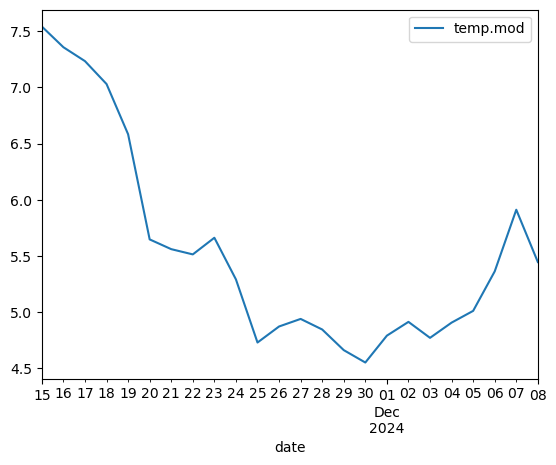

In [29]:
# Plot the forecast
forecast.plot(x="date", y="temp.mod", layout="compressed")

## Validation

To validate a forecast, specify the date it was run on.  The notebook will retrieve river temperature observations and evaluate performance.